In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
import sklearn as sk
import sklearn.discriminant_analysis as da
import sklearn.neighbors as knn
from IPython.display import Markdown, display
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation, ensemble, preprocessing, metrics
from sklearn.externals import joblib

%matplotlib inline

C:\Users\cdrgv\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('listings_new_york_2018.csv')

C:\Users\cdrgv\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (43,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 全部的columns名稱

In [3]:
df.columns.values

array(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'access',
       'interaction', 'house_rules', 'thumbnail_url', 'medium_url',
       'picture_url', 'xl_picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bath

## 把全部的分數相關的平均起來成新的column

In [4]:
col = df.loc[: , "review_scores_accuracy":"review_scores_value"]
df['review_scores_mean'] = col.mean(axis=1)


## 留下來的attributes

In [5]:
cols_to_keep = [
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price','review_scores_mean'
]
df = df[cols_to_keep]

## 清理price的符號 只剩下數字和小數點

In [6]:
df['price'] = df['price'].replace('[^(0-9).]','', regex=True).replace('[(]','-', regex=True).astype(float)

display(df.head())



,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,review_scores_mean
0,40.685384,-73.932709,Apartment,Private room,2,NaN,1.0,1.0,59.0,8.833333
1,40.799205,-73.953676,Apartment,Private room,3,1.0,1.0,3.0,59.0,9.166667
2,40.647486,-73.972370,Apartment,Private room,4,1.0,1.0,3.0,149.0,10.000000
3,40.753621,-73.983774,Apartment,Entire home/apt,2,1.0,0.0,1.0,225.0,9.500000
4,40.676947,-74.011209,House,Private room,4,1.0,1.0,1.0,89.0,7.833333


## 要預測的欄位 price換成log price

In [7]:
df['log_price'] = np.log(df['price'].values)


## drop price

In [8]:
data = df.drop('price', axis=1)
list(data.columns.values)
data.head()

,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,review_scores_mean,log_price
0,40.685384,-73.932709,Apartment,Private room,2,NaN,1.0,1.0,8.833333,4.077537
1,40.799205,-73.953676,Apartment,Private room,3,1.0,1.0,3.0,9.166667,4.077537
2,40.647486,-73.972370,Apartment,Private room,4,1.0,1.0,3.0,10.000000,5.003946
3,40.753621,-73.983774,Apartment,Entire home/apt,2,1.0,0.0,1.0,9.500000,5.416100
4,40.676947,-74.011209,House,Private room,4,1.0,1.0,1.0,7.833333,4.488636


## Missing Values 
找出各欄位有多少NAN

In [9]:
#Replace blanks with NaNs
data = data.replace('_', np.nan)
data = data.replace(' ', np.nan)
data = data.replace([np.inf, -np.inf], np.nan)
col_analysis = []
for column in data.columns:
    numNulls = len(data[column][data[column].isnull()])
    totalLength = len(data[column])
    dict1 = {'Name':column,'DataType':data[column].dtype, 'NumberOfNulls':numNulls, 'PercentageNulls':numNulls*100.0/totalLength}
    col_analysis.append(dict1)
    
col_anal_df = pd.DataFrame(col_analysis)[['Name', 'DataType','NumberOfNulls','PercentageNulls']].sort_values(by='PercentageNulls', ascending=False)

useful_cols = col_anal_df[col_anal_df.PercentageNulls < 50.0]

print('List of Predictors and their respective percentages of missing values')
display(useful_cols.head(28))

for cols in data.columns.values:
    if (np.any(useful_cols.Name.values == cols) == False):
        data.drop(cols, axis=1, inplace=True)
        
data.head(5)



List of Predictors and their respective percentages of missing values


,Name,DataType,NumberOfNulls,PercentageNulls
8,review_scores_mean,float64,11729,23.012478
5,bathrooms,float64,98,0.192278
7,beds,float64,61,0.119683
6,bedrooms,float64,56,0.109873
9,log_price,float64,26,0.051012
0,latitude,float64,0,0.000000
1,longitude,float64,0,0.000000
2,property_type,object,0,0.000000
3,room_type,object,0,0.000000
4,accommodates,int64,0,0.000000


,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,review_scores_mean,log_price
0,40.685384,-73.932709,Apartment,Private room,2,NaN,1.0,1.0,8.833333,4.077537
1,40.799205,-73.953676,Apartment,Private room,3,1.0,1.0,3.0,9.166667,4.077537
2,40.647486,-73.972370,Apartment,Private room,4,1.0,1.0,3.0,10.000000,5.003946
3,40.753621,-73.983774,Apartment,Entire home/apt,2,1.0,0.0,1.0,9.500000,5.416100
4,40.676947,-74.011209,House,Private room,4,1.0,1.0,1.0,7.833333,4.488636


## Impute Missing Values
把空白的填補成整個欄位的平均值

In [10]:
#Use Mean for Real values Columns
real_value_cols = useful_cols[useful_cols.DataType == 'float64']

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

data[real_value_cols.Name.values] = imp.fit_transform(data[real_value_cols.Name.values])
#Use Highest frequency for categorical columns
categorical_value_cols = useful_cols[useful_cols.DataType == 'object'].Name.values
data[categorical_value_cols] = data[categorical_value_cols].apply(lambda x:x.fillna(x.value_counts().index[0]))

data.head()
data.dtypes

latitude              float64
longitude             float64
property_type          object
room_type              object
accommodates            int64
bathrooms             float64
bedrooms              float64
beds                  float64
review_scores_mean    float64
log_price             float64
dtype: object

In [11]:

data = data.dropna()


## log_price的直方圖 (可以看出試常態分佈)

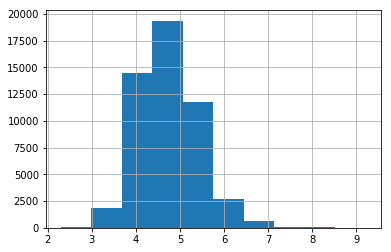

In [12]:
data.log_price.hist()

## Convert Categorical Variables to dummy integer values here
- We convert the categorical variables to numeric here such that we can run models that work only with numbers

## One-Hot Encoding
把nomial的欄位換成數字

In [13]:

data_ohe = data.copy(deep= True)

#Encode categorical variables
def encode_categorical(array):
    return preprocessing.LabelEncoder().fit_transform(array) 


categorical_value_cols = useful_cols[useful_cols.DataType == 'object'].Name.values

#print(categorical_value_cols)
#Convert Categories to numbers here


data_ohe[categorical_value_cols] = data_ohe[categorical_value_cols].apply(encode_categorical)


#data_ohe['property_type'] = data_ohe['property_type'].apply(encode_categorical)

# Apply one hot endcoing
# Leads to inferior performance and hence we disable for now
#data_ohe = pd.get_dummies(data_ohe.ix[:,:-1], columns=categorical_value_cols)

print ('Final Dataset ready for modelling after filling in missing values, and encoding categorical variables')
data_ohe.head()


Final Dataset ready for modelling after filling in missing values, and encoding categorical variables


,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,review_scores_mean,log_price
0,40.685384,-73.932709,1,1,2,1.142766,1.0,1.0,8.833333,4.077537
1,40.799205,-73.953676,1,1,3,1.000000,1.0,3.0,9.166667,4.077537
2,40.647486,-73.972370,1,1,4,1.000000,1.0,3.0,10.000000,5.003946
3,40.753621,-73.983774,1,0,2,1.000000,0.0,1.0,9.500000,5.416100
4,40.676947,-74.011209,19,1,4,1.000000,1.0,1.0,7.833333,4.488636


## Separate response from predictors

In [14]:

x = data_ohe.values[:, :-1]
y = data_ohe.values[:, -1]

#response = df_filtered[['log_price']]
#predictors =  df_filtered.drop(['log_price'], axis=1)

## Split into train/test

In [15]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

## Simple Regression Model

In [16]:
#OLS regression
clf = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
clf.fit(x_train, y_train)
predicted = clf.predict(x_test)

score = sk.metrics.r2_score(y_test, predicted)
print('sklearn: R2 score for Linear Regression is: {}'.format(score))

sklearn: R2 score for Linear Regression is: 0.5703453525474875


In [17]:
from sklearn import cross_validation, ensemble, preprocessing, metrics
# 建立 random forest 模型
forest = ensemble.RandomForestClassifier(n_estimators = 100)
y_train = np.array(y_train, dtype=int)
forest_fit = forest.fit(x_train, y_train)

# 預測
test_y_predicted = forest.predict(x_test)
y_test = np.array(y_test, dtype=int)
# 績效
score = sk.metrics.r2_score(y_test, test_y_predicted)
print('sklearn: R2 score for Random Forest is: {}'.format(score))

sklearn: R2 score for Linear Regression is: 0.4082299522656714


## 把model打包

In [18]:
joblib.dump(clf, 'predicted.pkl')
estimator = joblib.load('predicted.pkl')
estimator

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)